# **Laboratory Task 201**

### Kein Jake A. Culanggo
### DS4A

In [7]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

### **Dataset Source:**

https://www.kaggle.com/datasets/farukece/handwritten-japanese-hiragana-characters?resource=download

In [ ]:
root = r"C:\Users\Kein Jake\Downloads\hiragana\hiragana"

In [141]:
# Dataset Definition
class HiraganaDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.image_paths = []
        self.labels = []
        self.transforms = transforms

        subfolders = [f for f in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, f))]
        self.class_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

        for label, subfolder in enumerate(subfolders):
            subfolder_path = os.path.join(root, subfolder)
            for img_name in os.listdir(subfolder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(subfolder_path, img_name))
                    self.labels.append(label)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label_name = img_path.split(os.path.sep)[-2]
        label = self.class_map[label_name]

        if self.transforms:
            img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.image_paths)

#### **Dataset Class**

Okay, so think of the HiraganaDataset class as our way of teaching PyTorch how to grab the images and labels. We point it to the main folder, and it looks inside each subfolder. Each subfolder is a different Hiragana character. It collects all the image paths and gives each folder a number. That number is what the model will see as the label. When the model gets fed a batch of images, it knows which class each one belongs to.

#### **Loading a Sample**

When we grab one image with __getitem__, the class opens the image and converts it to RGB. We do this so the CNN does not get confused with channels. Then it looks at the folder name to figure out the label and applies any preprocessing we set up, like resizing, random rotation, or normalization. The cool thing is that all this happens on the fly, so we do not have to manually preprocess all 10,000 images before training. This saves memory and time.

#### **Why We Did It This Way**

This approach is flexible and neat. Using a custom dataset means we can swap datasets, tweak transforms, or filter classes easily without rewriting code. It also works perfectly with PyTorch’s DataLoader, so batching, shuffling, and parallel loading all just work. It keeps everything organized, clean, and ready for experiments without a bunch of manual work.

In [143]:
# Transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop(56, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#### **Transformations: Getting Images Ready**

Here we define how to preprocess the images before sending them into the model. We convert them to grayscale and resize to a fixed size so everything is uniform. The random resized crop and slight rotations add variability, which helps the model handle small shifts in the characters. We also apply a tiny chance of horizontal flipping. Finally, we turn the images into tensors and normalize them so training is smoother. These steps are mostly about consistency and giving the model a little extra robustness without overcomplicating things.

In [145]:
# Load Dataset and Split

dataset = HiraganaDataset(root=root, transforms=transform)

total = len(dataset)
train_size = max(int(0.8 * total), 1)
val_size = max(int(0.1 * total), 1)
test_size = max(total - train_size - val_size, 1)

generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=generator)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#### **Loading and Splitting the Dataset**

Once the dataset is ready, we create an instance of HiraganaDataset with our transforms. We calculate the total number of images and split them into training, validation, and test sets with roughly 80, 10, and 10 percent of the data. Using a fixed random seed ensures the split is reproducible. Then we wrap each subset in a DataLoader to handle batching and shuffling. Training batches are shuffled to avoid any order bias, while validation and test batches are not shuffled because we want consistent evaluation. This setup gives us a clean pipeline for feeding images into the model and evaluating performance reliably.

Classes in the dataset: ['aa', 'chi', 'ee', 'fu', 'ha', 'he', 'hi', 'ho', 'ii', 'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo', 'mu', 'na', 'ne', 'ni', 'nn', 'no', 'nu', 'oo', 'ra', 're', 'ri', 'ro', 'ru', 'sa', 'se', 'shi', 'so', 'su', 'ta', 'te', 'to', 'tsu', 'uu', 'wa', 'wo', 'ya', 'yo', 'yu']


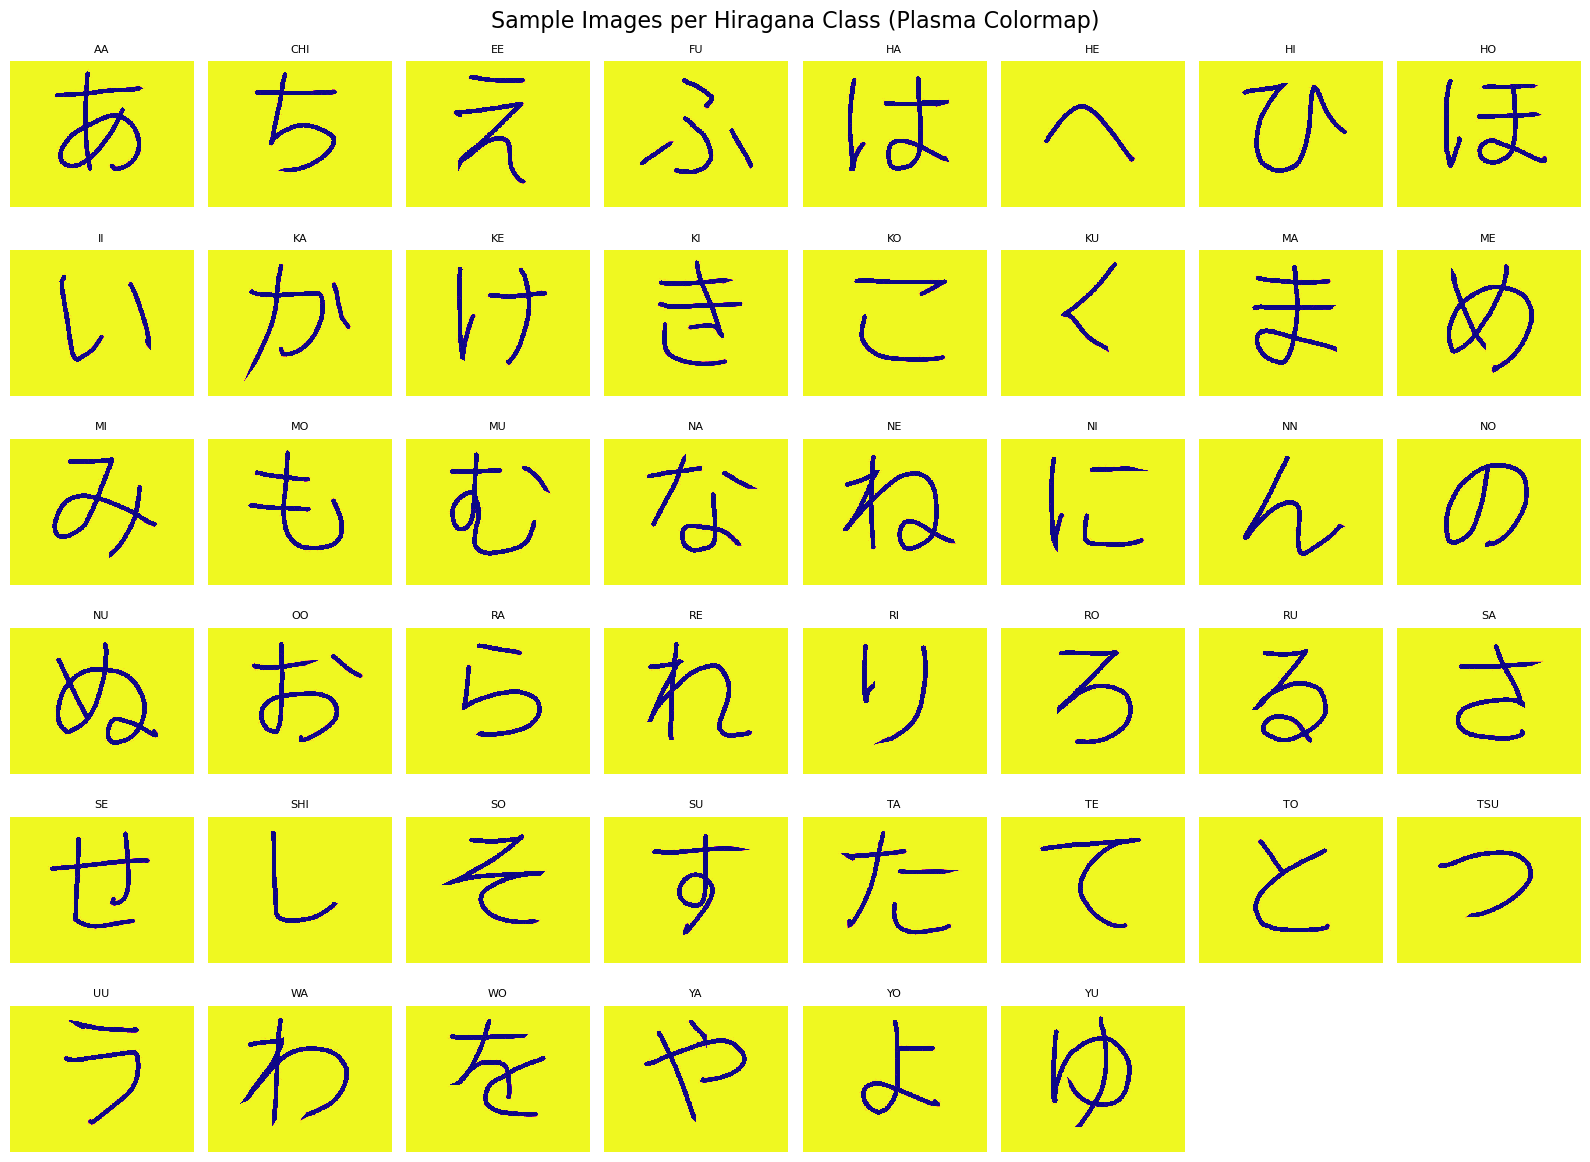

In [210]:
# List all classes as strings
class_list = [name for name, idx in sorted(dataset.class_map.items(), key=lambda x: x[1])]
print("Classes in the dataset:", class_list)

# Pick one sample per class
samples_per_class = {}
for img_path, label in zip(dataset.image_paths, dataset.labels):
    if label not in samples_per_class:
        samples_per_class[label] = img_path
    if len(samples_per_class) == len(dataset.class_map):
        break

# Plot samples
num_classes = len(dataset.class_map)
cols = 8
rows = int(np.ceil(num_classes / cols))
plt.figure(figsize=(cols * 2, rows * 2))
plt.suptitle("Sample Images per Hiragana Class (Plasma Colormap)", fontsize=16)

for i, (label, img_path) in enumerate(sorted(samples_per_class.items())):
    img = Image.open(img_path).convert("L")  # grayscale
    img_np = np.array(img)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_np, cmap='plasma', interpolation='nearest')
    plt.title(class_list[label].upper(), fontsize=8)  # label is int index
    plt.axis('off')

plt.tight_layout()
plt.show()

In [151]:
# CNN Definition (Activation function as parameter)
class HiraganaCNN(nn.Module):
    def __init__(self, num_classes=63, activation_fn=nn.ReLU):
        super(HiraganaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            activation_fn(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation_fn(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            activation_fn(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 512),
            activation_fn(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### **CNN Definition: Flexible Activation Functions**

This is our core model, HiraganaCNN. It’s a fairly standard CNN, but we made it flexible by letting the activation function be a parameter. That way, we can easily swap ReLU, LeakyReLU, ELU, or others without changing the rest of the architecture. The feature extractor has three convolutional layers, each followed by the chosen activation, batch normalization, and max pooling to reduce spatial dimensions. After the convolutional blocks, we flatten the features and pass them through a small fully connected classifier with one hidden layer, the same activation, and dropout for regularization. The last layer outputs raw logits for each class, which works perfectly with CrossEntropyLoss during training. This setup keeps the architecture consistent while allowing us to experiment with different activation functions to see how they affect training and performance.

In [155]:
# Experiment Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activation_functions = {
    'ReLU': nn.ReLU,
    'LeakyReLU': nn.LeakyReLU,
    'ELU': nn.ELU
}

optimizers_dict = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}

num_epochs = 20
learning_rate = 0.0007

#### **Experiment Setup: Activations, Optimizers, and Device**

Here we set up the experiment environment. First, we choose whether to run on GPU or CPU. Then we define the activation functions and optimizers we want to test. The idea is to keep the CNN architecture the same and only change the activation function or optimizer in each run to see how they affect performance. We also set the number of epochs and the learning rate so every experiment is comparable. This way, we can fairly evaluate which combination trains fastest, generalizes best, and achieves the highest accuracy.

In [157]:
# Experiment Loop
experiment_results = []

for act_name, act_fn in activation_functions.items():
    for opt_name, opt_fn in optimizers_dict.items():
        print(f"\n--- Training with Activation: {act_name}, Optimizer: {opt_name} ---")

        model = HiraganaCNN(num_classes=len(dataset.class_map), activation_fn=act_fn).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opt_fn(model.parameters(), lr=learning_rate)

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0
        best_epoch = 0
        best_model_state = None

        for epoch in range(num_epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in tqdm(train_loader, leave=False):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            train_acc = 100 * correct / total
            avg_train_loss = running_loss / len(train_loader)

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)
            val_acc = 100 * val_correct / val_total
            avg_val_loss = val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                best_model_state = model.state_dict()

            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Load best model for testing
        model.load_state_dict(best_model_state)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        test_acc = 100 * correct / total
        print(f"Best Epoch: {best_epoch}, Test Accuracy: {test_acc:.2f}%")

        # Store results
        experiment_results.append({
            'Activation': act_name,
            'Optimizer': opt_name,
            'Best Epoch': best_epoch,
            'Test Accuracy': test_acc,
            'Train Loss': train_losses,
            'Val Loss': val_losses,
            'Train Acc': train_accs,
            'Val Acc': val_accs
        })


--- Training with Activation: ReLU, Optimizer: Adam ---


Epoch [1/20] Train Loss: 1.7632, Train Acc: 55.79% | Val Loss: 0.4167, Val Acc: 87.83%


Epoch [2/20] Train Loss: 0.3335, Train Acc: 90.57% | Val Loss: 0.1372, Val Acc: 95.87%


Epoch [3/20] Train Loss: 0.2098, Train Acc: 93.83% | Val Loss: 0.0562, Val Acc: 98.26%


Epoch [4/20] Train Loss: 0.1388, Train Acc: 95.62% | Val Loss: 0.0679, Val Acc: 98.48%


Epoch [5/20] Train Loss: 0.0997, Train Acc: 97.07% | Val Loss: 0.0291, Val Acc: 98.91%


Epoch [6/20] Train Loss: 0.0726, Train Acc: 97.74% | Val Loss: 0.0236, Val Acc: 99.35%


Epoch [7/20] Train Loss: 0.0773, Train Acc: 97.47% | Val Loss: 0.0163, Val Acc: 99.13%


Epoch [8/20] Train Loss: 0.0587, Train Acc: 98.48% | Val Loss: 0.0378, Val Acc: 98.70%


Epoch [9/20] Train Loss: 0.0640, Train Acc: 98.21% | Val Loss: 0.0092, Val Acc: 99.78%


Epoch [10/20] Train Loss: 0.0435, Train Acc: 98.78% | Val Loss: 0.0059, Val Acc: 99.78%


Epoch [11/20] Train Loss: 0.0379, Train Acc: 98.97% | Val Loss: 0.0200, Val Acc: 99.13%


Epoch [12/20] Train Loss: 0.0352, Train Acc: 98.86% | Val Loss: 0.0298, Val Acc: 99.57%


Epoch [13/20] Train Loss: 0.0417, Train Acc: 98.75% | Val Loss: 0.0195, Val Acc: 99.35%


Epoch [14/20] Train Loss: 0.0468, Train Acc: 98.42% | Val Loss: 0.0412, Val Acc: 98.26%


Epoch [15/20] Train Loss: 0.0413, Train Acc: 98.61% | Val Loss: 0.0126, Val Acc: 99.78%


Epoch [16/20] Train Loss: 0.0546, Train Acc: 98.21% | Val Loss: 0.0058, Val Acc: 99.78%


Epoch [17/20] Train Loss: 0.0577, Train Acc: 97.91% | Val Loss: 0.0129, Val Acc: 99.13%


Epoch [18/20] Train Loss: 0.0318, Train Acc: 98.99% | Val Loss: 0.0173, Val Acc: 99.35%


Epoch [19/20] Train Loss: 0.0283, Train Acc: 99.05% | Val Loss: 0.0033, Val Acc: 99.78%


Epoch [20/20] Train Loss: 0.0370, Train Acc: 98.75% | Val Loss: 0.0046, Val Acc: 99.78%
Best Epoch: 9, Test Accuracy: 99.13%

--- Training with Activation: ReLU, Optimizer: SGD ---


Epoch [1/20] Train Loss: 3.8524, Train Acc: 3.34% | Val Loss: 3.7002, Val Acc: 9.35%


Epoch [2/20] Train Loss: 3.6791, Train Acc: 7.36% | Val Loss: 3.5735, Val Acc: 18.04%


Epoch [3/20] Train Loss: 3.5380, Train Acc: 12.42% | Val Loss: 3.3834, Val Acc: 34.57%


Epoch [4/20] Train Loss: 3.3703, Train Acc: 20.60% | Val Loss: 3.2334, Val Acc: 50.87%


Epoch [5/20] Train Loss: 3.1878, Train Acc: 28.56% | Val Loss: 3.0232, Val Acc: 57.17%


Epoch [6/20] Train Loss: 2.9941, Train Acc: 37.69% | Val Loss: 2.7969, Val Acc: 66.96%


Epoch [7/20] Train Loss: 2.7777, Train Acc: 44.46% | Val Loss: 2.5560, Val Acc: 75.65%


Epoch [8/20] Train Loss: 2.5646, Train Acc: 50.84% | Val Loss: 2.3235, Val Acc: 77.61%


Epoch [9/20] Train Loss: 2.3590, Train Acc: 55.65% | Val Loss: 2.0841, Val Acc: 82.61%


Epoch [10/20] Train Loss: 2.1542, Train Acc: 61.82% | Val Loss: 1.8695, Val Acc: 84.57%


Epoch [11/20] Train Loss: 1.9639, Train Acc: 64.78% | Val Loss: 1.6887, Val Acc: 87.61%


Epoch [12/20] Train Loss: 1.7843, Train Acc: 69.54% | Val Loss: 1.5460, Val Acc: 87.39%


Epoch [13/20] Train Loss: 1.6246, Train Acc: 71.58% | Val Loss: 1.3457, Val Acc: 88.91%


Epoch [14/20] Train Loss: 1.4626, Train Acc: 74.76% | Val Loss: 1.2365, Val Acc: 90.00%


Epoch [15/20] Train Loss: 1.3495, Train Acc: 75.27% | Val Loss: 1.0755, Val Acc: 88.91%


Epoch [16/20] Train Loss: 1.2273, Train Acc: 77.66% | Val Loss: 0.9871, Val Acc: 89.13%


Epoch [17/20] Train Loss: 1.1295, Train Acc: 80.11% | Val Loss: 0.9084, Val Acc: 89.57%


Epoch [18/20] Train Loss: 1.0429, Train Acc: 81.44% | Val Loss: 0.8650, Val Acc: 90.65%


Epoch [19/20] Train Loss: 0.9496, Train Acc: 82.61% | Val Loss: 0.7616, Val Acc: 90.65%


Epoch [20/20] Train Loss: 0.9401, Train Acc: 81.96% | Val Loss: 0.6636, Val Acc: 93.91%
Best Epoch: 20, Test Accuracy: 89.78%

--- Training with Activation: ReLU, Optimizer: RMSprop ---


Epoch [1/20] Train Loss: 3.7615, Train Acc: 35.92% | Val Loss: 0.9260, Val Acc: 76.52%


Epoch [2/20] Train Loss: 0.7984, Train Acc: 77.31% | Val Loss: 0.3060, Val Acc: 92.39%


Epoch [3/20] Train Loss: 0.4424, Train Acc: 87.04% | Val Loss: 0.1920, Val Acc: 95.87%


Epoch [4/20] Train Loss: 0.2960, Train Acc: 91.11% | Val Loss: 0.1021, Val Acc: 97.61%


Epoch [5/20] Train Loss: 0.2246, Train Acc: 93.40% | Val Loss: 0.0406, Val Acc: 98.70%


Epoch [6/20] Train Loss: 0.1796, Train Acc: 94.86% | Val Loss: 0.0643, Val Acc: 98.70%


Epoch [7/20] Train Loss: 0.1415, Train Acc: 95.30% | Val Loss: 0.0394, Val Acc: 98.70%


Epoch [8/20] Train Loss: 0.1152, Train Acc: 96.68% | Val Loss: 0.0333, Val Acc: 98.70%


Epoch [9/20] Train Loss: 0.1266, Train Acc: 95.90% | Val Loss: 0.0309, Val Acc: 98.48%


Epoch [10/20] Train Loss: 0.1154, Train Acc: 96.52% | Val Loss: 0.0271, Val Acc: 99.35%


Epoch [11/20] Train Loss: 0.0869, Train Acc: 96.93% | Val Loss: 0.0135, Val Acc: 99.78%


Epoch [12/20] Train Loss: 0.0853, Train Acc: 97.64% | Val Loss: 0.0226, Val Acc: 99.57%


Epoch [13/20] Train Loss: 0.0732, Train Acc: 97.93% | Val Loss: 1.8305, Val Acc: 76.74%


Epoch [14/20] Train Loss: 0.0618, Train Acc: 98.02% | Val Loss: 0.0133, Val Acc: 99.35%


Epoch [15/20] Train Loss: 0.0809, Train Acc: 97.20% | Val Loss: 0.0035, Val Acc: 100.00%


Epoch [16/20] Train Loss: 0.0499, Train Acc: 98.32% | Val Loss: 0.0069, Val Acc: 99.78%


Epoch [17/20] Train Loss: 0.0634, Train Acc: 98.02% | Val Loss: 0.0204, Val Acc: 99.35%


Epoch [18/20] Train Loss: 0.0645, Train Acc: 98.07% | Val Loss: 0.0165, Val Acc: 99.35%


Epoch [19/20] Train Loss: 0.0644, Train Acc: 98.37% | Val Loss: 0.0245, Val Acc: 99.35%


Epoch [20/20] Train Loss: 0.0691, Train Acc: 98.02% | Val Loss: 0.0183, Val Acc: 99.78%
Best Epoch: 15, Test Accuracy: 99.78%

--- Training with Activation: LeakyReLU, Optimizer: Adam ---


Epoch [1/20] Train Loss: 1.7697, Train Acc: 56.58% | Val Loss: 0.4279, Val Acc: 90.65%


Epoch [2/20] Train Loss: 0.3262, Train Acc: 91.09% | Val Loss: 0.1229, Val Acc: 96.74%


Epoch [3/20] Train Loss: 0.1620, Train Acc: 95.00% | Val Loss: 0.0789, Val Acc: 98.04%


Epoch [4/20] Train Loss: 0.1038, Train Acc: 96.88% | Val Loss: 0.0355, Val Acc: 98.91%


Epoch [5/20] Train Loss: 0.0799, Train Acc: 97.55% | Val Loss: 0.0447, Val Acc: 98.70%


Epoch [6/20] Train Loss: 0.0798, Train Acc: 97.80% | Val Loss: 0.0352, Val Acc: 99.13%


Epoch [7/20] Train Loss: 0.0615, Train Acc: 98.18% | Val Loss: 0.0239, Val Acc: 99.13%


Epoch [8/20] Train Loss: 0.0789, Train Acc: 97.53% | Val Loss: 0.0095, Val Acc: 99.78%


Epoch [9/20] Train Loss: 0.0659, Train Acc: 98.04% | Val Loss: 0.0109, Val Acc: 99.78%


Epoch [10/20] Train Loss: 0.0586, Train Acc: 98.34% | Val Loss: 0.0057, Val Acc: 100.00%


Epoch [11/20] Train Loss: 0.0431, Train Acc: 98.78% | Val Loss: 0.0066, Val Acc: 99.78%


Epoch [12/20] Train Loss: 0.0324, Train Acc: 98.91% | Val Loss: 0.0188, Val Acc: 99.57%


Epoch [13/20] Train Loss: 0.0408, Train Acc: 98.75% | Val Loss: 0.0120, Val Acc: 99.57%


Epoch [14/20] Train Loss: 0.0355, Train Acc: 98.91% | Val Loss: 0.0072, Val Acc: 99.57%


Epoch [15/20] Train Loss: 0.0293, Train Acc: 99.10% | Val Loss: 0.0021, Val Acc: 100.00%


Epoch [16/20] Train Loss: 0.0553, Train Acc: 98.34% | Val Loss: 0.0165, Val Acc: 99.57%


Epoch [17/20] Train Loss: 0.0464, Train Acc: 98.64% | Val Loss: 0.0075, Val Acc: 99.78%


Epoch [18/20] Train Loss: 0.0341, Train Acc: 98.91% | Val Loss: 0.0170, Val Acc: 99.35%


Epoch [19/20] Train Loss: 0.0228, Train Acc: 99.21% | Val Loss: 0.0016, Val Acc: 100.00%


Epoch [20/20] Train Loss: 0.0267, Train Acc: 99.10% | Val Loss: 0.0210, Val Acc: 99.35%
Best Epoch: 10, Test Accuracy: 99.57%

--- Training with Activation: LeakyReLU, Optimizer: SGD ---


Epoch [1/20] Train Loss: 3.8427, Train Acc: 3.51% | Val Loss: 3.6947, Val Acc: 5.87%


Epoch [2/20] Train Loss: 3.6835, Train Acc: 7.55% | Val Loss: 3.5623, Val Acc: 21.30%


Epoch [3/20] Train Loss: 3.5239, Train Acc: 13.45% | Val Loss: 3.3824, Val Acc: 39.35%


Epoch [4/20] Train Loss: 3.3568, Train Acc: 20.87% | Val Loss: 3.2200, Val Acc: 48.48%


Epoch [5/20] Train Loss: 3.1780, Train Acc: 29.92% | Val Loss: 2.9948, Val Acc: 62.17%


Epoch [6/20] Train Loss: 2.9684, Train Acc: 37.83% | Val Loss: 2.7692, Val Acc: 69.57%


Epoch [7/20] Train Loss: 2.7524, Train Acc: 45.76% | Val Loss: 2.5459, Val Acc: 74.13%


Epoch [8/20] Train Loss: 2.5351, Train Acc: 52.77% | Val Loss: 2.3071, Val Acc: 80.87%


Epoch [9/20] Train Loss: 2.3285, Train Acc: 57.50% | Val Loss: 2.1008, Val Acc: 81.09%


Epoch [10/20] Train Loss: 2.1433, Train Acc: 61.68% | Val Loss: 1.8260, Val Acc: 86.30%


Epoch [11/20] Train Loss: 1.9199, Train Acc: 66.11% | Val Loss: 1.6581, Val Acc: 85.22%


Epoch [12/20] Train Loss: 1.7505, Train Acc: 68.89% | Val Loss: 1.4876, Val Acc: 87.61%


Epoch [13/20] Train Loss: 1.6245, Train Acc: 70.30% | Val Loss: 1.3349, Val Acc: 88.48%


Epoch [14/20] Train Loss: 1.4539, Train Acc: 74.84% | Val Loss: 1.1025, Val Acc: 90.87%


Epoch [15/20] Train Loss: 1.3249, Train Acc: 76.96% | Val Loss: 1.0524, Val Acc: 91.30%


Epoch [16/20] Train Loss: 1.2314, Train Acc: 78.67% | Val Loss: 0.9565, Val Acc: 92.17%


Epoch [17/20] Train Loss: 1.1119, Train Acc: 79.84% | Val Loss: 0.8646, Val Acc: 91.96%


Epoch [18/20] Train Loss: 1.0648, Train Acc: 81.01% | Val Loss: 0.7875, Val Acc: 90.65%


Epoch [19/20] Train Loss: 0.9870, Train Acc: 82.26% | Val Loss: 0.7692, Val Acc: 92.61%


Epoch [20/20] Train Loss: 0.9270, Train Acc: 82.66% | Val Loss: 0.7205, Val Acc: 91.30%
Best Epoch: 19, Test Accuracy: 89.57%

--- Training with Activation: LeakyReLU, Optimizer: RMSprop ---


Epoch [1/20] Train Loss: 2.9318, Train Acc: 48.10% | Val Loss: 0.5673, Val Acc: 86.09%


Epoch [2/20] Train Loss: 0.5500, Train Acc: 84.29% | Val Loss: 0.1109, Val Acc: 96.52%


Epoch [3/20] Train Loss: 0.2744, Train Acc: 92.01% | Val Loss: 0.0775, Val Acc: 97.39%


Epoch [4/20] Train Loss: 0.1728, Train Acc: 94.76% | Val Loss: 0.1176, Val Acc: 97.39%


Epoch [5/20] Train Loss: 0.1296, Train Acc: 96.09% | Val Loss: 0.0465, Val Acc: 98.48%


Epoch [6/20] Train Loss: 0.1168, Train Acc: 96.33% | Val Loss: 0.0407, Val Acc: 98.26%


Epoch [7/20] Train Loss: 0.0858, Train Acc: 97.45% | Val Loss: 0.0235, Val Acc: 99.35%


Epoch [8/20] Train Loss: 0.0911, Train Acc: 97.39% | Val Loss: 0.0392, Val Acc: 98.26%


Epoch [9/20] Train Loss: 0.0852, Train Acc: 97.34% | Val Loss: 0.0140, Val Acc: 99.35%


Epoch [10/20] Train Loss: 0.0865, Train Acc: 97.34% | Val Loss: 0.0101, Val Acc: 99.57%


Epoch [11/20] Train Loss: 0.0611, Train Acc: 98.07% | Val Loss: 0.0098, Val Acc: 99.57%


Epoch [12/20] Train Loss: 0.0502, Train Acc: 98.45% | Val Loss: 0.0316, Val Acc: 99.13%


Epoch [13/20] Train Loss: 0.0500, Train Acc: 98.21% | Val Loss: 0.0266, Val Acc: 98.91%


Epoch [14/20] Train Loss: 0.0742, Train Acc: 97.83% | Val Loss: 0.0729, Val Acc: 99.35%


Epoch [15/20] Train Loss: 0.0487, Train Acc: 98.45% | Val Loss: 0.0727, Val Acc: 97.83%


Epoch [16/20] Train Loss: 0.0492, Train Acc: 98.51% | Val Loss: 0.0026, Val Acc: 100.00%


Epoch [17/20] Train Loss: 0.0436, Train Acc: 98.80% | Val Loss: 0.0072, Val Acc: 99.78%


Epoch [18/20] Train Loss: 0.0508, Train Acc: 98.75% | Val Loss: 0.0240, Val Acc: 99.13%


Epoch [19/20] Train Loss: 0.0391, Train Acc: 98.83% | Val Loss: 0.0474, Val Acc: 99.13%


Epoch [20/20] Train Loss: 0.0453, Train Acc: 98.86% | Val Loss: 0.0260, Val Acc: 99.13%
Best Epoch: 16, Test Accuracy: 99.35%

--- Training with Activation: ELU, Optimizer: Adam ---


Epoch [1/20] Train Loss: 2.0360, Train Acc: 49.57% | Val Loss: 0.3395, Val Acc: 92.61%


Epoch [2/20] Train Loss: 0.4230, Train Acc: 87.69% | Val Loss: 0.2322, Val Acc: 95.65%


Epoch [3/20] Train Loss: 0.2370, Train Acc: 93.10% | Val Loss: 0.2363, Val Acc: 94.13%


Epoch [4/20] Train Loss: 0.1528, Train Acc: 95.35% | Val Loss: 0.1193, Val Acc: 97.83%


Epoch [5/20] Train Loss: 0.1163, Train Acc: 96.30% | Val Loss: 0.0371, Val Acc: 99.13%


Epoch [6/20] Train Loss: 0.0920, Train Acc: 97.42% | Val Loss: 0.0339, Val Acc: 98.91%


Epoch [7/20] Train Loss: 0.0779, Train Acc: 97.72% | Val Loss: 0.0173, Val Acc: 99.57%


Epoch [8/20] Train Loss: 0.0545, Train Acc: 98.15% | Val Loss: 0.0126, Val Acc: 99.57%


Epoch [9/20] Train Loss: 0.0542, Train Acc: 98.32% | Val Loss: 0.0211, Val Acc: 99.35%


Epoch [10/20] Train Loss: 0.0578, Train Acc: 98.26% | Val Loss: 0.0300, Val Acc: 99.35%


Epoch [11/20] Train Loss: 0.0523, Train Acc: 98.48% | Val Loss: 0.0334, Val Acc: 98.91%


Epoch [12/20] Train Loss: 0.0413, Train Acc: 98.59% | Val Loss: 0.0420, Val Acc: 98.70%


Epoch [13/20] Train Loss: 0.0454, Train Acc: 98.64% | Val Loss: 0.0131, Val Acc: 99.78%


Epoch [14/20] Train Loss: 0.0495, Train Acc: 98.37% | Val Loss: 0.0239, Val Acc: 99.13%


Epoch [15/20] Train Loss: 0.0559, Train Acc: 98.32% | Val Loss: 0.0209, Val Acc: 99.13%


Epoch [16/20] Train Loss: 0.0550, Train Acc: 98.42% | Val Loss: 0.0200, Val Acc: 99.13%


Epoch [17/20] Train Loss: 0.0337, Train Acc: 98.83% | Val Loss: 0.0014, Val Acc: 100.00%


Epoch [18/20] Train Loss: 0.0507, Train Acc: 98.45% | Val Loss: 0.0082, Val Acc: 99.57%


Epoch [19/20] Train Loss: 0.0351, Train Acc: 98.97% | Val Loss: 0.0028, Val Acc: 100.00%


Epoch [20/20] Train Loss: 0.0444, Train Acc: 98.56% | Val Loss: 0.0145, Val Acc: 99.57%
Best Epoch: 17, Test Accuracy: 98.04%

--- Training with Activation: ELU, Optimizer: SGD ---


Epoch [1/20] Train Loss: 3.8047, Train Acc: 4.43% | Val Loss: 3.6393, Val Acc: 11.30%


Epoch [2/20] Train Loss: 3.6005, Train Acc: 9.43% | Val Loss: 3.4644, Val Acc: 23.04%


Epoch [3/20] Train Loss: 3.3761, Train Acc: 19.78% | Val Loss: 3.2472, Val Acc: 42.39%


Epoch [4/20] Train Loss: 3.1784, Train Acc: 31.22% | Val Loss: 2.9896, Val Acc: 60.00%


Epoch [5/20] Train Loss: 2.9653, Train Acc: 42.58% | Val Loss: 2.8263, Val Acc: 69.13%


Epoch [6/20] Train Loss: 2.7357, Train Acc: 52.55% | Val Loss: 2.6035, Val Acc: 75.65%


Epoch [7/20] Train Loss: 2.5198, Train Acc: 59.40% | Val Loss: 2.3541, Val Acc: 77.17%


Epoch [8/20] Train Loss: 2.3298, Train Acc: 64.46% | Val Loss: 2.1940, Val Acc: 78.91%


Epoch [9/20] Train Loss: 2.1456, Train Acc: 68.18% | Val Loss: 1.9831, Val Acc: 86.30%


Epoch [10/20] Train Loss: 1.9768, Train Acc: 70.79% | Val Loss: 1.7835, Val Acc: 85.22%


Epoch [11/20] Train Loss: 1.8087, Train Acc: 73.99% | Val Loss: 1.6454, Val Acc: 86.52%


Epoch [12/20] Train Loss: 1.6747, Train Acc: 75.90% | Val Loss: 1.4855, Val Acc: 86.52%


Epoch [13/20] Train Loss: 1.5505, Train Acc: 78.04% | Val Loss: 1.3870, Val Acc: 86.96%


Epoch [14/20] Train Loss: 1.4572, Train Acc: 78.37% | Val Loss: 1.3232, Val Acc: 86.30%


Epoch [15/20] Train Loss: 1.3567, Train Acc: 80.00% | Val Loss: 1.2141, Val Acc: 88.04%


Epoch [16/20] Train Loss: 1.2668, Train Acc: 81.58% | Val Loss: 1.0598, Val Acc: 89.35%


Epoch [17/20] Train Loss: 1.1935, Train Acc: 81.90% | Val Loss: 1.0498, Val Acc: 88.91%


Epoch [18/20] Train Loss: 1.1110, Train Acc: 83.18% | Val Loss: 0.9811, Val Acc: 90.22%


Epoch [19/20] Train Loss: 1.0423, Train Acc: 84.21% | Val Loss: 0.8030, Val Acc: 92.83%


Epoch [20/20] Train Loss: 0.9814, Train Acc: 85.00% | Val Loss: 0.8522, Val Acc: 90.00%
Best Epoch: 19, Test Accuracy: 91.96%

--- Training with Activation: ELU, Optimizer: RMSprop ---


Epoch [1/20] Train Loss: 4.2791, Train Acc: 39.84% | Val Loss: 0.7989, Val Acc: 82.61%


Epoch [2/20] Train Loss: 0.8349, Train Acc: 76.77% | Val Loss: 0.5516, Val Acc: 85.65%


Epoch [3/20] Train Loss: 0.4699, Train Acc: 86.79% | Val Loss: 0.2179, Val Acc: 93.48%


Epoch [4/20] Train Loss: 0.3179, Train Acc: 91.03% | Val Loss: 0.1569, Val Acc: 94.57%


Epoch [5/20] Train Loss: 0.2133, Train Acc: 93.26% | Val Loss: 0.0888, Val Acc: 98.26%


Epoch [6/20] Train Loss: 0.1677, Train Acc: 95.11% | Val Loss: 0.0848, Val Acc: 97.83%


Epoch [7/20] Train Loss: 0.1579, Train Acc: 95.43% | Val Loss: 0.1139, Val Acc: 97.17%


Epoch [8/20] Train Loss: 0.1427, Train Acc: 95.90% | Val Loss: 0.1192, Val Acc: 96.09%


Epoch [9/20] Train Loss: 0.1207, Train Acc: 96.74% | Val Loss: 0.0279, Val Acc: 99.13%


Epoch [10/20] Train Loss: 0.1131, Train Acc: 96.98% | Val Loss: 0.0203, Val Acc: 99.57%


Epoch [11/20] Train Loss: 0.0930, Train Acc: 97.15% | Val Loss: 0.0233, Val Acc: 99.35%


Epoch [12/20] Train Loss: 0.0831, Train Acc: 97.47% | Val Loss: 0.0511, Val Acc: 98.70%


Epoch [13/20] Train Loss: 0.0834, Train Acc: 97.55% | Val Loss: 0.0097, Val Acc: 99.78%


Epoch [14/20] Train Loss: 0.0643, Train Acc: 97.91% | Val Loss: 0.0358, Val Acc: 98.70%


Epoch [15/20] Train Loss: 0.0788, Train Acc: 98.10% | Val Loss: 0.0123, Val Acc: 99.35%


Epoch [16/20] Train Loss: 0.0560, Train Acc: 98.10% | Val Loss: 0.0455, Val Acc: 98.26%


Epoch [17/20] Train Loss: 0.0704, Train Acc: 97.91% | Val Loss: 0.0235, Val Acc: 99.78%


Epoch [18/20] Train Loss: 0.0512, Train Acc: 98.51% | Val Loss: 0.0238, Val Acc: 99.13%


Epoch [19/20] Train Loss: 0.0596, Train Acc: 98.10% | Val Loss: 0.0323, Val Acc: 98.70%


Epoch [20/20] Train Loss: 0.0611, Train Acc: 98.15% | Val Loss: 0.0020, Val Acc: 100.00%
Best Epoch: 20, Test Accuracy: 99.13%


#### **Experiment Loop: Training and Tracking Results**

This is the core of our experiments. **We loop through every combination of activation function and optimizer.** For each run, we create a fresh CNN with the selected activation, set up the loss function, and initialize the optimizer.

Inside the epoch loop, we first train the model on the training set. We keep track of running loss and the number of correct predictions to calculate accuracy. After each epoch, we switch to evaluation mode and measure performance on the validation set. We store the losses and accuracies for both training and validation, so we can plot them later.

We also **keep track of the best validation accuracy** and which epoch achieved it. At the end of each experiment, we reload the best model weights and measure test accuracy.

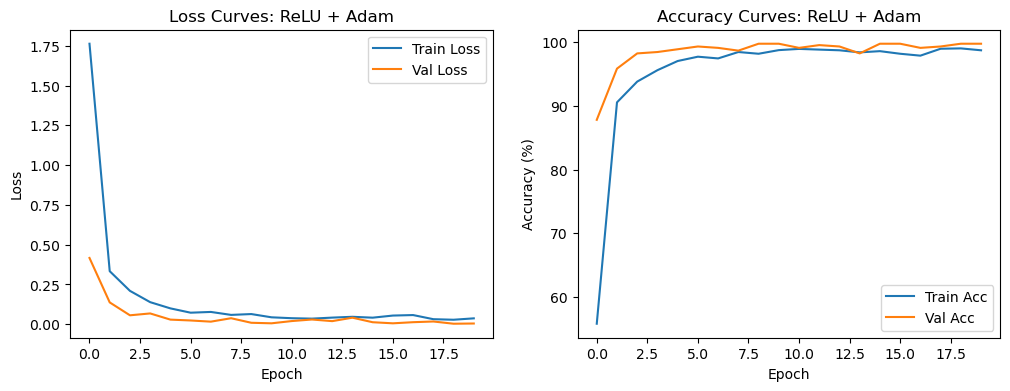

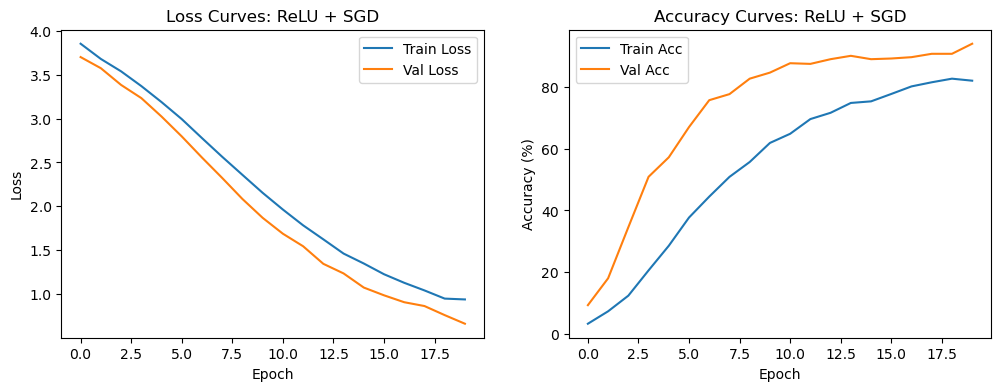

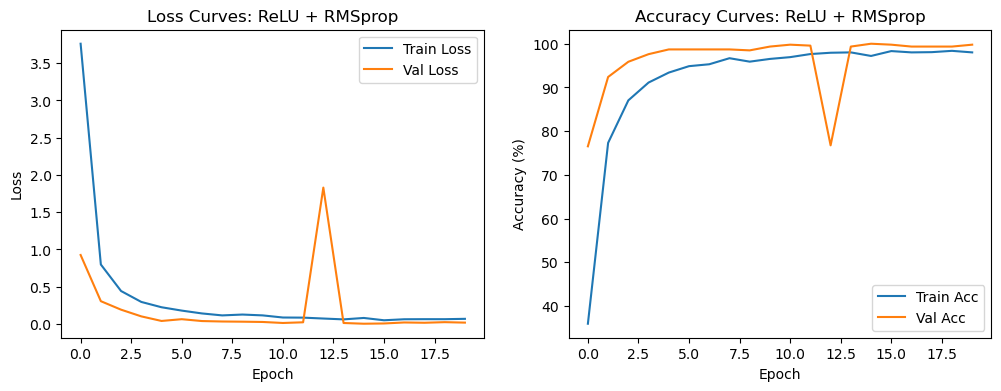

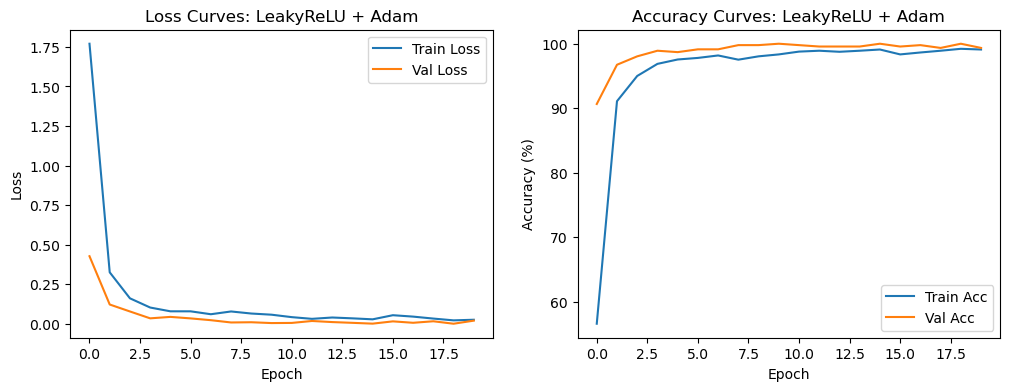

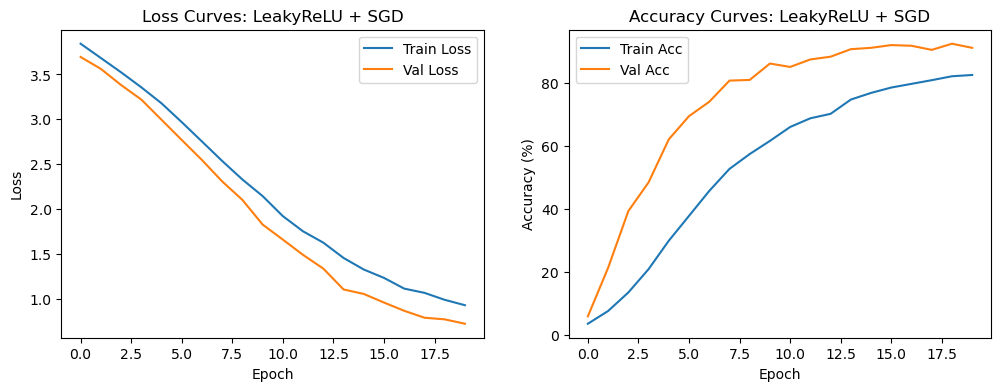

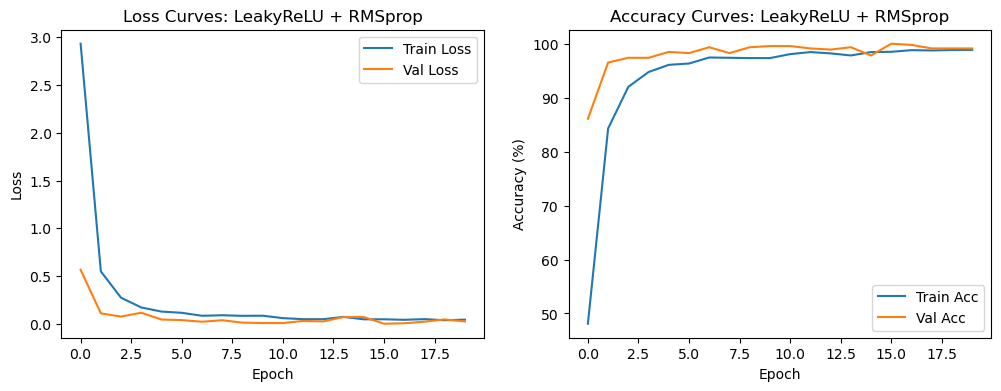

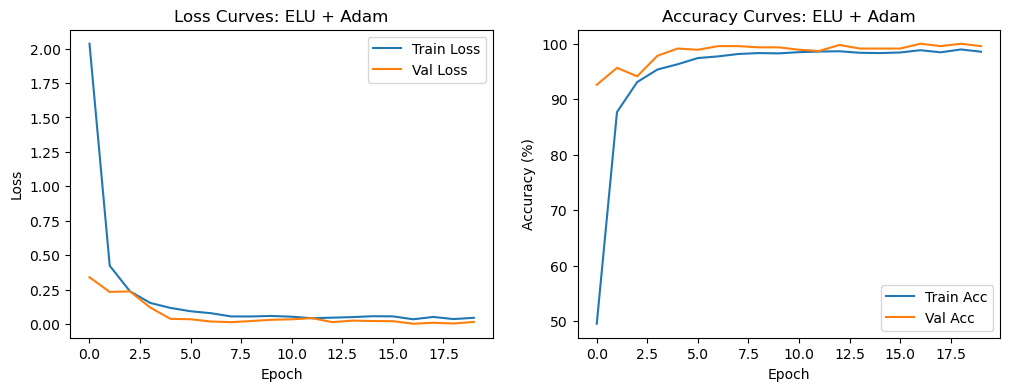

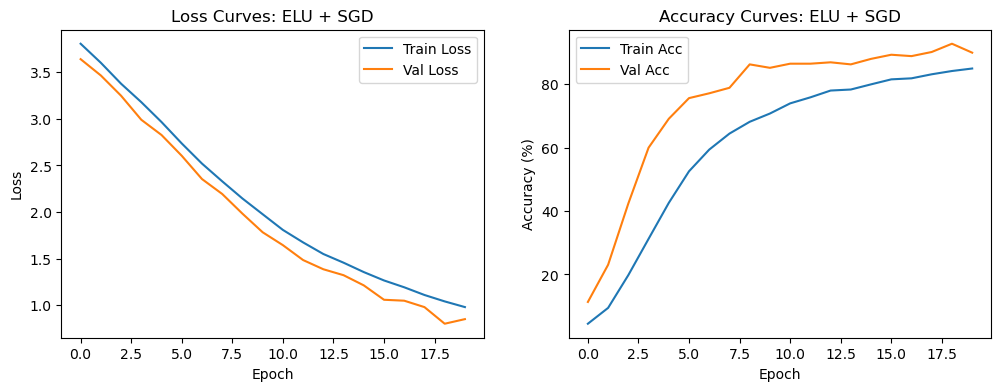

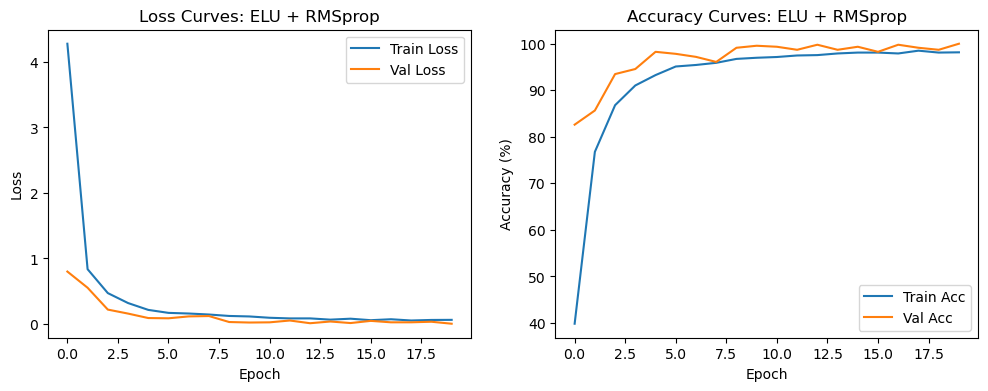

In [176]:
# Plot Loss/Accuracy Curves for All Experiments
for result in experiment_results:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(result['Train Loss'], label='Train Loss')
    plt.plot(result['Val Loss'], label='Val Loss')
    plt.title(f"Loss Curves: {result['Activation']} + {result['Optimizer']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(result['Train Acc'], label='Train Acc')
    plt.plot(result['Val Acc'], label='Val Acc')
    plt.title(f"Accuracy Curves: {result['Activation']} + {result['Optimizer']}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

### Key Takeaways

#### ReLU Activation Function

- **Adam:** The model converges quickly, with training and validation losses dropping sharply and stabilizing near zero around epochs 5–10. Accuracies rise rapidly, reaching approximately **99.13%** on the test set. Validation accuracy is slightly higher than training after epoch 2. Best epoch: **9**.  

- **RMSprop:** Losses drop quickly, but a noticeable spike occurs in validation loss around epoch 12. Accuracies mirror this behavior, with validation accuracy dipping before stabilizing. Test accuracy is approximately **99.78%**. Best epoch: **15**.  

- **SGD:** Convergence is slower. Losses decline steadily over 20 epochs. Test accuracy is approximately **89.78%**, indicating the model has not fully converged. Best epoch: **20**.  

---

#### LeakyReLU Activation Function

- **Adam:** Both losses drop sharply and stabilize near zero around epochs 5–10. Test accuracy reaches approximately **99.57%**. Best epoch: **10**.  

- **RMSprop:** Losses drop sharply and stabilize near zero by epoch 5. Test accuracy reaches approximately **99.35%**. Best epoch: **16**.  

- **SGD:** Convergence is slower. Test accuracy reaches approximately **89.57%**, indicating partial convergence. Best epoch: **19**.  

---

#### ELU Activation Function

- **Adam:** Losses drop sharply and stabilize near zero around epoch 5. Test accuracy reaches approximately **98.04%**. Best epoch: **17**.  

- **RMSprop:** Losses decrease sharply from a high starting point and stabilize near zero by epoch 5. Test accuracy reaches **99.13%**. Best epoch: **20**.  

- **SGD:** Convergence is slower. Test accuracy reaches approximately **91.96%**, indicating partial convergence. Best epoch: **19**.

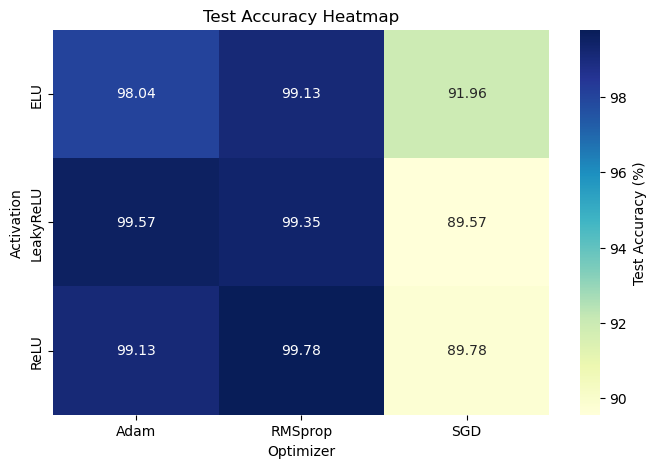

In [193]:
heatmap_data = summary.pivot(index='Activation', columns='Optimizer', values='Test Accuracy')

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Test Accuracy (%)'})
plt.title('Test Accuracy Heatmap')
plt.show()

In [216]:
# Summary Table
import pandas as pd

summary = pd.DataFrame([{
    'Activation': r['Activation'],
    'Optimizer': r['Optimizer'],
    'Best Epoch': r['Best Epoch'],
    'Test Accuracy': r['Test Accuracy']
} for r in experiment_results])

print("\n📊 Summary of All Experiments")
display(summary.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True))


📊 Summary of All Experiments


,Activation,Optimizer,Best Epoch,Test Accuracy
0,ReLU,RMSprop,15,99.782609
1,LeakyReLU,Adam,10,99.565217
2,LeakyReLU,RMSprop,16,99.347826
3,ReLU,Adam,9,99.130435
4,ELU,RMSprop,20,99.130435
5,ELU,Adam,17,98.043478
6,ELU,SGD,19,91.956522
7,ReLU,SGD,20,89.782609
8,LeakyReLU,SGD,19,89.565217


### **Conclusion**

From this lab activity, several key insights emerged regarding the impact of activation functions and optimizers on the performance of convolutional neural networks. We observed that both the choice of activation function and optimizer significantly influence the convergence speed, stability, and final accuracy of the model. Specifically, **ReLU and LeakyReLU** combined with adaptive optimizers such as **Adam and RMSprop** achieved the highest test accuracies, **consistently above 99%,** while SGD generally lagged, showing slower convergence and lower final accuracy.

This task allowed us to practice designing systematic experiments where only select hyperparameters are varied while keeping all others constant. Through this approach, we were able to isolate the effect of activations and optimizers on model performance. The experiments also emphasized the importance of monitoring both training and validation metrics to detect issues such as overfitting, spikes in loss, or slow convergence.

Challenges included handling the variability of convergence across optimizer-activation combinations and understanding the subtle interactions between activation functions and gradient-based optimizers. It was also evident that some combinations, while achieving high training accuracy, could overfit, as indicated by discrepancies between training and validation metrics.

#### **Bottomline:** 

Looking back to the results we achieved, **Adam** and **RMSprop** are clearly the more reliable optimizers for this task, consistently achieving above 99 percent with **ReLU** or **LeakyReLU.** SGD is noticeably slower and less stable. For this dataset, simpler activations like ReLU and LeakyReLU edge out ELU slightly, especially when paired with adaptive optimizers. If we were to pick one combination for deployment or further experiments, ReLU + RMSprop or ReLU + Adam would be the safest bet, balancing fast convergence with top accuracy.

Overall, this activity reinforced our understanding of how hyperparameters shape learning dynamics. It trained us to interpret model behavior through quantitative metrics, visualize trends in loss and accuracy, and make informed decisions when tuning deep learning models. Beyond coding, it cultivated a mindset of experimentation, critical analysis, and methodical evaluation that will be crucial in future machine learning tasks.